# Classification Tree: Start to Finish

The data set that we are going to use for this notebook is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Here is a link to the [dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease). We will use this dataset to predict whether or not a person has heart disease.

The procedure that we are going to follow here: 

* Importing the Data
* Missing Data
    * Identifying Missing Data
    * Dealing with Missing Data
* Formatting the Data for Decision Trees
    * Splitting data into Dependent and Independent Variables
    * One-Hot-Encoding
* Building a Preliminary Classification Tree
* Optimizing the tree with Cost Complexity Pruning
    * Visualizing Alpha
    * Using Cross Validation to find the best values of alpha
* Building, Drawing, Interpreting and Evaluating the Final Decision Tree

## Importing the Libraries

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the Dataset

We are going to use the [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+disease). This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

In [210]:
# we will import the dataset directly from the website of UCI, instead of downloading the pdf onto our device and then reading it.
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                header = None)
df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Instead of colunm names, we are getting column numbers. Since column names would make it easier for us to work with, we are going to convert the column numbers into names with the following column names:
* age
* sex
* cp (chest pain)
* restbp (resting blood pressure, in mmHg)
* chol (serum cholesterol in mg/dl)
* fbs (fasting blood pressure)
* restecg (resting electrocardiographic results)
* thalach (maximum heart rate achieved)
* exang (exercise induced angina)
* oldpeak (ST depression induced by exercise relative to rest)
* slope (the slope of the peak exercise ST segment)
* ca (number of major vessels, 0-3, colored by fluroscopy)
* thal (this is hort of thalium heart scan)
* hd (diagnosis of heart disease, the predicted atrribute)

In [211]:
df.columns = ['age', 'sex', 'cp','restbp', 'chol', 'fbs', 'restecg', 'thalach', 
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Dealing with Missing Data

There are two main ways to deal with missing data:

* We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for **age** and **age**is not useful for classifying if people have heart disease or not, then it would be a shame to throw out all of someone's data just because we do not have their **age**.
* We can impute the values that are missing. In this conext compute is just a fancy way of saying "we can make and educated guess about what the values should be". Continuing our example where are missing a value for **age**, instead of throwing out the entire row of data, we can fill the missing value with the average age or the medain age, or use some other, more sophisticated approch, to guess at an appropriate value.

In [212]:
# dtypes tells us the "data type" for each column
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

We see that **ca** and **thal** have data types as *object*. *object* datatype is usually used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should have just have a few values representing differnt categories, so let's investigate what's going on by printing out their unique values. We will start with **ca**:

In [213]:
# Pring out the unique values in the column called 'ca'
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0, 1.0) and question mark (?). The number represents the number of blood vessels that we lut up by fluroscopy and the question marks represents the missing data. 

Let's do the same wiht **thal**:

In [214]:
# Pring out the unique values in the column called 'thal'
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

We see that **thal** contains numbers (6.0, 3.0, 7.0) and question mark(?). The numbers represents the different diagnoses from the thalium heart scum, and question mark represents missing data.

Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do with these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [215]:
# loc[] is short for location.
len(df.loc[(df['ca'] == '?')
            | 
            (df['thal'] == '?') ] )

6

Since only 6 rows have missing values, let's look at them.

In [216]:
df.loc[
    (df['ca'] == '?') | (df['thal'] == '?')
]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [217]:
# Counts the number of rows in the full dataset
len(df)

303

In [218]:
print(( round(6/303 * (100))), "%")

2 %


So $2%$ contain missing values. Since $303-6=297$ is plenty of data to build a classificaiton tree, we will remove the rows with missing data values, rather than try to impute their values.

In [219]:
df_no_missing = df.loc[ 
    (df['ca'] != '?') & (df['thal'] != '?')
]

len(df_no_missing)

297

*df_no_missing* has 6 fewer rows than the original dataset as we thought. Let's check the unique values of **ca** and **thal** in the new dataset.

In [220]:
print(df_no_missing['ca'].unique())
print(df_no_missing['thal'].unique())

['0.0' '3.0' '2.0' '1.0']
['6.0' '3.0' '7.0']


Now, there is no more missing data in the dataset and we are ready to format the data for making a classification tree.

## Spliting the Data into Dependent and Independent Variables

We know that **hd** represents heart disease, so we will name it "y" and all others columns as "X".

In [221]:
X = df_no_missing.drop('hd', axis=1)
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [222]:
y = df_no_missing['hd']
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

Now we will further inspect "X".

In [223]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

We see that **age**, **restbp**, **chol**, and **thalach** are all *float64*, which is good because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasoable values, and some of them need to change. This is because, while **scikit learn Decision Tree** natively support continuous data, like **restbp**  and **thalach**. They do not support categorical data, like **cp** which contain 4 differnt categories. Thus, in order to use categorical data with **scikit learn decision tree**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point, you may be wondering, "What's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example:

For the **cp** column, we have 4 options
* typical angina
* atypical angina
* non-anginal pain
* asymptomatic

If we treated these values 1, 2, 3, and 4 like continuous data then we would assume that 4, which means (asymptomatic) is more similar to 3 which means "non-anginal pain" than it is to 1 and 2 (other types of chest pain). That means the decision tree would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s. 

In contrast, if we treat these like categorical data, then we treat each one as a separate category that is no more or less imilar to any of the other categories. Thus, the likelihood of clustering patients with 4s and 3s is the same clustering 4s and 1s, and this approach does not sound reasonable.

Now, let's inspect and, if needed, convert the columns that contain categorical and integer data into correct datatypes. We will start with **cp** by inspecting all of its unique values:

In [224]:
X['cp'].unique()

array([1., 4., 3., 2.])

Since we already dealt with missing data, we will use **One-Hot Encoding**, and convert the **cp** into a series of columns that only contain 0's and 1's.

In [225]:
X['cp'].unique()

array([1., 4., 3., 2.])

Since there is not missing data in "X" now, we can perform One-hot Encoding.

There are many ways to do it in Python. Two of the most popular methods are *ColumnTransformer()* (from *scikit learn*) and *get_dummies()* (from pandas). 

A con of using *ColumnTransformer()* is that it will convert the dataset into an array and will lose all the columns that we assigned earlier. In contrast, *get_dummies()* leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. 

In [226]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


As we can see, the dataframe has new columns separated for **cp**. Now we know how *get_dummies()* work, we will use it on the four categorical caolumns that have more than 2 categories.

**NOTE**: In a real life situation, you should verify all 5 of these new columns only contain the accepted categories!! 

In [227]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restbp', 'slope', 'thal'])

X_encoded.head()

,age,sex,chol,fbs,restecg,thalach,exang,oldpeak,ca,cp_1.0,...,restbp_178.0,restbp_180.0,restbp_192.0,restbp_200.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,233.0,1.0,2.0,150.0,0.0,2.3,0.0,1,...,0,0,0,0,0,0,1,0,1,0
1,67.0,1.0,286.0,0.0,2.0,108.0,1.0,1.5,3.0,0,...,0,0,0,0,0,1,0,1,0,0
2,67.0,1.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,0,...,0,0,0,0,0,1,0,0,0,1
3,37.0,1.0,250.0,0.0,0.0,187.0,0.0,3.5,0.0,0,...,0,0,0,0,0,0,1,1,0,0
4,41.0,0.0,204.0,0.0,2.0,172.0,0.0,1.4,0.0,0,...,0,0,0,0,1,0,0,1,0,0


There are 3 more columns that contain cateogorical data and those are **sex**, **fbs**, and **exang**.

As we can see that **One-Hot Encoding** converts a column with more than 2 categories into multiple columns of 0's and 1's. Since **sex**, **fbs**, and **exang** only have 2 categories and only contain 0 and 1's to begin with, we do not need to have to do anything special to them, so we are done with formatting the data for the Classification Tree.

Last thing before we build the tree. *y* does not have just contain 0s and 1s. Instead, it has 5 different levels of heart disease.

0 = no heart disease and 1-4 are various degrees of heart disease. We can see this below:

In [228]:
y.unique()

array([0, 2, 1, 3, 4])

Since we are only making a tree that predicts if a person has a heart disease or not, we will convert the 5 different levels of heart diseases into 2 in the following way:

0 = no heart disease and 1-4 = heart disease.

In [229]:
y_not_zero_index = (y > 0)  # get the index for each non-zero value in y
y[y_not_zero_index] = 1     # set each non-zero value in y to 1
y.unique()

<ipython-input-229-01d29338f9ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y_not_zero_index] = 1     # set each non-zero value in y to 1
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


array([0, 1])

## Building a Classification Tree

In [230]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)

# Create a decision tree and fit it to the training data
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

[Text(502.84056122448976, 392.0192307692308, 'ca <= 0.5\ngini = 0.498\nsamples = 222\nvalue = [118, 104]\nclass = No HD'),
 Text(301.0637755102041, 360.6576923076923, 'thal_7.0 <= 0.5\ngini = 0.382\nsamples = 132\nvalue = [98, 34]\nclass = No HD'),
 Text(183.62755102040816, 329.29615384615386, 'oldpeak <= 2.7\ngini = 0.24\nsamples = 93\nvalue = [80, 13]\nclass = No HD'),
 Text(128.1122448979592, 297.93461538461537, 'age <= 58.5\ngini = 0.185\nsamples = 87\nvalue = [78, 9]\nclass = No HD'),
 Text(68.3265306122449, 266.5730769230769, 'restbp_136.0 <= 0.5\ngini = 0.061\nsamples = 63\nvalue = [61, 2]\nclass = No HD'),
 Text(34.16326530612245, 235.21153846153845, 'restbp_108.0 <= 0.5\ngini = 0.032\nsamples = 61\nvalue = [60, 1]\nclass = No HD'),
 Text(17.081632653061224, 203.85, 'gini = 0.0\nsamples = 59\nvalue = [59, 0]\nclass = No HD'),
 Text(51.244897959183675, 203.85, 'sex <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = No HD'),
 Text(34.16326530612245, 172.48846153846154, 'gin

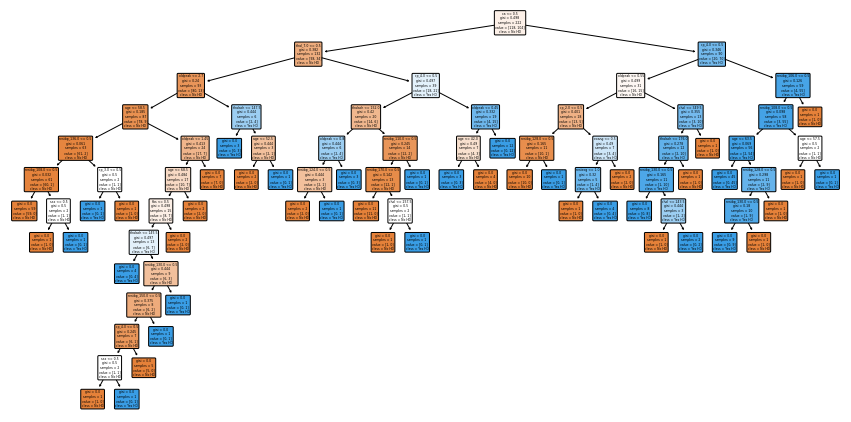

In [231]:
# Let's plot the tree
from sklearn.tree import plot_tree
plt.figure(figsize= (15, 7.5))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names = X_encoded.columns)


There is our Decision Tree!! Looks small but amazing!! 

Let's see how it performs on the Testing dataset.

In [232]:
from sklearn.model_selection import cross_val_score    # For cross validation 
from sklearn.metrics import confusion_matrix           # to create a confusion matrix
from sklearn.metrics import accuracy_score             # To output accuracy score of the model
from sklearn.metrics import plot_confusion_matrix      # To plot confusion Matrix

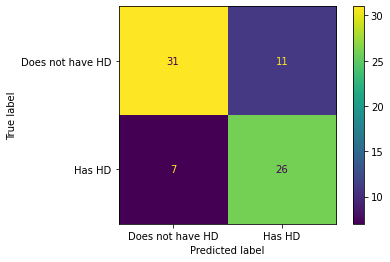

In [233]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

In [234]:
y_pred = clf_dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.76

In the confusion matrix, we see that $31$ people were correctly classified who have Heart Disease. That means $31/(31+11) = 74 \%$ were correctly classified. 

And out of $7 + 26 = 33$ people that have Heart Disease, $26 (79\%)$ were correctly classified.

Can we do better? One thing that might be holding this Classification Tree back is that it may have overfit the training dataset. So, let's prune the tree. Pruning, in theory, should solve the overfitting problem and gives us better results.

# Cost Complexity Pruning Part 1: Visualize alpha

**Decision Trees** are known to being overfit to the Training dataset, and there are a lot of parameters, like *max_depth* and *min_samples*, that are designed to reduce overfitting. However, pruning a tree with **cost complexity pruning** can simplify the whole process of finding a smaller tree that improves the accuracy with the Testing Dataset.

Pruning a decision tree is all about finding the right value for the pruning parameter, *alpha*, which controls how little or how much pruning happens. One to find the optimal value for *alpha* is to plot the accuracy of the tree as a function values. We will do this for both the Training Dataset and the Testing Dataset. 

First, let's extract the different values of *alpha* that are avaiable for this tree and build a pruned tree for each value for *alpha*.

**Note**: We omit the maximum value for alpha with *ccp_alphas = ccp_alphas[:-1]* because it would prune all leaves, leaving us with only a root instead of a tree.

In [235]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)    # Determines the values for alpha
ccp_alphas = path.ccp_alphas       # Extract different values for alpha
ccp_alphas = ccp_alphas[: -1]      # Excluding the maximum value for alpha

clf_dts = []                        # Create an array that we will put decision trees into

# Now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)


Now, lets graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset**  as a function of the alpha.

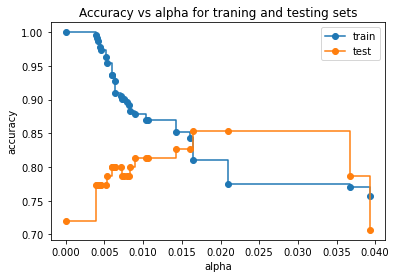

In [236]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for traning and testing sets")
ax.plot(ccp_alphas, train_scores, marker = 'o', label = "train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o', label = "test", drawstyle = "steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the Testing Dataset hits its maximum value when **alpha** is about **0.016**. After this value for **alpha**, the accuracy of the Training Dataset drops off and that suggests we should set **ccp_alpha = 0.016**.

**Note**: When we apply **Cost Complexity Pruning** to a **Classification Tree**, values for *alpha*goes from 0 from 1, because GINI Scores goes from 0 to 1. In contrast values for *alpha* for a **Regression Tree** can be much larger since the sum of squared residuals can, in theory, go from 0 to $\infty$.

Since there are many ways we could have divided the original into Training and Testing Datasets, how do we know we used the best Training Dataset and how do we know we used the best Testing Dataset? 

Typically, we answer this question with **10-Fold Cross Validation**. So that's what we are going to do now, and we will do it with the *cross_val_score()* function.

## Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graph we just drew suggested one value for alpha, **0.016**, but another set of data might suggest another optimal value.

First, let's demonstrate that different training and testing datasets result in trees with different accuracies when we set *ccp_alpha = 0.016*. We will do this by using the *cross_val_score()* function to generate different training and testing datasets and then train and test the tree with those datasets.

<AxesSubplot:xlabel='tree'>

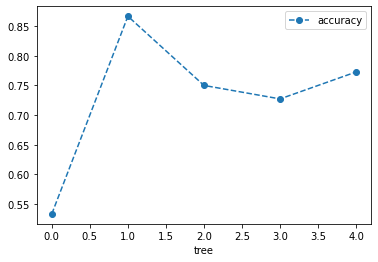

In [237]:
clf_dt = DecisionTreeClassifier(random_state= 42, ccp_alpha=0.016)

# Now use 5-fold cross validation. Create 5 different training and tesing datasets that 
# are then used to train and test the tree
# NOTE: we use 5-fold because we do not have tons of data...

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores} )

df.plot(x = 'tree', y = 'accuracy', marker = 'o', linestyle = '--')

The graph above shows that using different **Training** and **Tesing** data with the same alpha resulted in different accuracies, suggesting that alpha is sensitive to the datasets. So, instead of picking a single a single **Training** dataset and single **Testing** dataset, let's use **cross-validation** to find the optimal value for *cpp_alpha*.

<AxesSubplot:xlabel='alpha'>

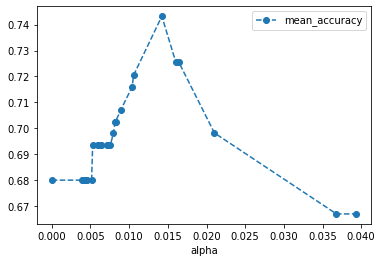

In [238]:
# Create an array to store the results of each fold during cross validation
alpha_loop_values = []

# For each candidate value for alpha, we will run 5-fold cross validation
# Then we will store the mean and standard deviation of the scores (the accuracy) for each cal
# to cross_val_score in alpha_loop_values...

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Now we can draw a graph of the means and standard deviations of the scores 
# for each candidate value for alpha

alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x = 'alpha',
                   y = 'mean_accuracy',
                   marker = 'o',
                   linestyle = '--')


Using Cross validation, we can see that, over all, instead of setting *cpp_alpha = 0.016*, we need to set it to something closer to 0.014. We can find the exact value with:

In [239]:
alpha_results[
    (alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)
]

,alpha,mean_accuracy,std
21,0.014225,0.743232,0.091736


Now let's store the ideal value for alpha so that we can use it to build the best tree.

In [240]:
ideal_ccp_alpha = alpha_results[
    (alpha_results['alpha'] > 0.014) & (alpha_results['alpha'] < 0.015)
]['alpha']

ideal_ccp_alpha

21    0.014225
Name: alpha, dtype: float64

**NOTE**: At this point, Python things that *ideal_ccp_alpha* is a series, which is a type of array. We can tell because when we printed *ideal_cpp_alpha* out, we got two bits of stuff. The first one was 21, which is the index in the series, the second, 0.014225, is the value we want. So we can convert this from a series to a float with the following command:

In [241]:
# Convert ideal_ccp_alpha from a series to a float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

**YAYAYA!!** Now we have the ideal value for *alpha* and we can build, evaluate and draw the final **Classification Tree**.

## Building, Evaluating, Drawing and Interpreting the Final Classification Tree

Now that we have the ideal value for *alpha*, we can build the final **Classification Tree** by setting *ccp_alpha = ideal_cpp_alpha*:

In [242]:
# Build and train a new decision tree, only this time use the optimal value for alpha
clf_dt_pruned = DecisionTreeClassifier(random_state=0,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

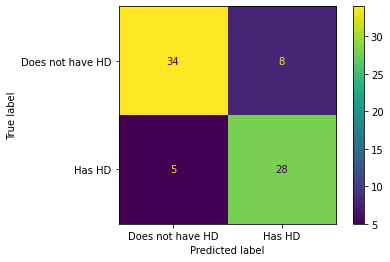

In [243]:
plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=["Does not have HD", "Has HD"])

We see that pruned tree is better at classifying patients than the full sized tree.

Here, total number of patients who does not Heart Disease are 42. Our model predicted 34 of them correctly and 8 incorrectly, giving us an accuracy of $81\%$.

Again, total number of patients who has a Heart Disease are 33. Out of those, our model predicted 28 correctly and 5 incorrectly, giving us an accuracy of $79\%$.

These accuracies are better than our first model.

The last thing we are going to do is draw the pruned tree and disuss how to interpret it

[Text(482.8846153846154, 380.52, 'ca <= 0.5\ngini = 0.498\nsamples = 222\nvalue = [118, 104]\nclass = No HD'),
 Text(257.53846153846155, 271.8, 'thal_7.0 <= 0.5\ngini = 0.382\nsamples = 132\nvalue = [98, 34]\nclass = No HD'),
 Text(128.76923076923077, 163.07999999999998, 'oldpeak <= 2.7\ngini = 0.24\nsamples = 93\nvalue = [80, 13]\nclass = No HD'),
 Text(64.38461538461539, 54.360000000000014, 'gini = 0.185\nsamples = 87\nvalue = [78, 9]\nclass = No HD'),
 Text(193.15384615384616, 54.360000000000014, 'gini = 0.444\nsamples = 6\nvalue = [2, 4]\nclass = Yes HD'),
 Text(386.3076923076923, 163.07999999999998, 'cp_4.0 <= 0.5\ngini = 0.497\nsamples = 39\nvalue = [18, 21]\nclass = Yes HD'),
 Text(321.9230769230769, 54.360000000000014, 'gini = 0.42\nsamples = 20\nvalue = [14, 6]\nclass = No HD'),
 Text(450.69230769230774, 54.360000000000014, 'gini = 0.332\nsamples = 19\nvalue = [4, 15]\nclass = Yes HD'),
 Text(708.2307692307693, 271.8, 'cp_4.0 <= 0.5\ngini = 0.346\nsamples = 90\nvalue = [20, 70

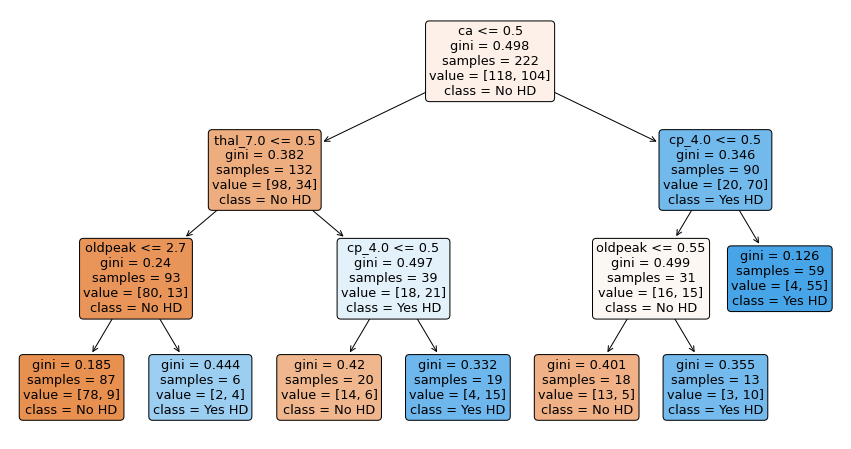

In [244]:
plt.figure(figsize=(15, 8))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=X_encoded.columns)